#%%############################################################################
# IMPORTANT COMMENTS README
###############################################################################
# This code demonstrates Lasso Logistic Regression and Decision Tree Classification
# using a loan default dataset. It includes data loading, preprocessing, model training,
# hyperparameter tuning, and evaluation with relevant metrics and visualizations.
# Note: Ensure the 'kagglehub' package is installed to download datasets from Kaggle.

#%%############################################################################
# SETUP: IMPORTS AND DATA LOADING
###############################################################################




In [1]:
#import some packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn. model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (recall_score, roc_auc_score, accuracy_score, precision_score,
                             f1_score, confusion_matrix, ConfusionMatrixDisplay)

from sklearn.preprocessing import StandardScaler
import kagglehub # pyright: ignore[reportMissingImports]

#Download latest version
path = kagglehub.dataset_download("nikhil1e9/loan-default")

print("Path to dataset directory:", path)


#Construct the full path to the CSV file
csv_file_path = os.path.join(path, 'loan_default.csv')
print("Full path to CSV file:", csv_file_path)

dropbox_path="/Users/delro/OneDrive/Documents/myanalysis"
os.chdir(dropbox_path)

C:\Users\delro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset directory: C:\Users\delro\.cache\kagglehub\datasets\nikhil1e9\loan-default\versions\2
Full path to CSV file: C:\Users\delro\.cache\kagglehub\datasets\nikhil1e9\loan-default\versions\2\loan_default.csv


In [2]:
#load the full dataset using the correct file path
data_decision_trees = pd.read_csv(csv_file_path, header=0)

print(data_decision_trees.columns)
print(data_decision_trees.info())
print(data_decision_trees.isnull().sum())

#drop observations with missing values
df_filtered = data_decision_trees[(data_decision_trees['CreditScore'] >=600) &
                                  (data_decision_trees['CreditScore'] <=699) &
                                  (data_decision_trees['Age'] >= 22) &
                                  (data_decision_trees['Age'] <= 64)]
data_for_modeling = df_filtered[df_filtered['LoanPurpose'] == 'Auto'].copy()

print(f"Shape of data after filtering: {data_for_modeling.shape}")
data_for_modeling.groupby('LoanPurpose').size()

numerical_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
categorical_cols = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

means_comparison = pd.DataFrame({
    'Medium-Low Credit Score Group': data_for_modeling[numerical_cols].mean(),
    'Entire Group': data_decision_trees[numerical_cols].mean()
})
print("Mean Comparison:\n", means_comparison)

Index(['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore',
       'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
       'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner',
       'Default'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       25534

#%%###################################################################
# 3. FEATURE ENGINEERING
# Create all new predictive features from the existing data.
######################################################################

# Income and Loan Dynamics

In [3]:
data_for_modeling['Income_to_Loan_Ratio'] = data_for_modeling['Income'] / data_for_modeling['LoanAmount']
data_for_modeling['Log_Income'] = np.log1p(data_for_modeling['Income'])
data_for_modeling['Log_LoanAmount'] = np.log1p(data_for_modeling['LoanAmount'])
data_for_modeling['Age_by_IncomeLoanRatio'] = data_for_modeling['Age'] * data_for_modeling['Income_to_Loan_Ratio']
data_for_modeling['LoanTerm_by_InterestRate'] = data_for_modeling['LoanTerm'] * data_for_modeling['InterestRate']

# Employment Stability - A ratio to assess job stability relative to age

data_for_modeling['EmploymentStability'] = data_for_modeling['MonthsEmployed'] / data_for_modeling['Age']

# Credit Profile and Burden
data_for_modeling['InterestRate_Squared'] = data_for_modeling['InterestRate']**2
data_for_modeling['MonthlyBurden'] = data_for_modeling['InterestRate'] / data_for_modeling['LoanTerm']

print(f"Shape of data BEFORE feature engineering: {df_filtered.shape}")
print(f"Shape of data after feature engineering: {data_for_modeling.shape}")
print("New features created.")

Shape of data BEFORE feature engineering: (38401, 18)
Shape of data after feature engineering: (7601, 26)
New features created.


# --- Create Separate DataFrames for a Dual-Pipeline Approach ---

In [4]:
data_for_ohe = data_for_modeling.copy() # For One-Hot Encoding Path
data_for_le = data_for_modeling.copy()  # For Label Encoding Path


#%%##########################################################################################
# 4. CATEGORICAL ENCODING & PREPARING FINAL FEATURE SET
# Convert categorical object columns to numerical format.
#############################################################################################


In [5]:
print("\n --- Performing One-Hot Encoding ---")

categorical_cols = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
data_encoded_ohe = pd.get_dummies(data_for_ohe, columns=categorical_cols, drop_first=True)

y_ohe = data_encoded_ohe['Default']
X_ohe = data_encoded_ohe.drop(columns=['Default', 'LoanID'])

print(f"Shape of features (X) after encoding: {X_ohe.shape}")
print(X_ohe.columns)


 --- Performing One-Hot Encoding ---
Shape of features (X) after encoding: (7601, 28)
Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
       'Income_to_Loan_Ratio', 'Log_Income', 'Log_LoanAmount',
       'Age_by_IncomeLoanRatio', 'LoanTerm_by_InterestRate',
       'EmploymentStability', 'InterestRate_Squared', 'MonthlyBurden',
       'Education_High School', 'Education_Master's', 'Education_PhD',
       'EmploymentType_Part-time', 'EmploymentType_Self-employed',
       'EmploymentType_Unemployed', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'HasMortgage_Yes', 'HasDependents_Yes',
       'HasCoSigner_Yes'],
      dtype='object')


#%%#########################################################################################
# 5. DATA BALANCING (UNDERSAMPLING)
# Balance the dataset to ensure the model doesn't get biased by the majority class.
############################################################################################

In [6]:
print("\n ---Balancing Data Via Undersampling ---")

non_default_indices = X_ohe[y_ohe == 0].index
default_indices = X_ohe[y_ohe == 1].index
np.random.seed(123)
selected_non_default_indices = np.random.choice(non_default_indices, size=len(default_indices), replace=False)

balanced_indices = np.concatenate([selected_non_default_indices, default_indices])
X_balanced_ohe = X_ohe.loc[balanced_indices]
y_balanced_ohe = y_ohe.loc[balanced_indices]

print("Class Distribution After UnderSampling:")
print(y_balanced_ohe.value_counts(normalize=True))

# Should be ~0.5 for each class


 ---Balancing Data Via Undersampling ---
Class Distribution After UnderSampling:
0    0.5
1    0.5
Name: Default, dtype: float64


#%%########################################################################################
# 6. DATA SPLITTING
# Split into training, validation, and test sets
###########################################################################################

In [7]:
print("\n---Splitting Data into Train, Validation, and Test Sets ---")



#split into training validation and test sets (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X_balanced_ohe, y_balanced_ohe, test_size=0.2, random_state=0, shuffle=True, stratify= y_balanced_ohe)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=0, shuffle=True, stratify=y_temp)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


---Splitting Data into Train, Validation, and Test Sets ---
Training set shape: (1038, 28)
Validation set shape: (347, 28)
Test set shape: (347, 28)


#%%############################################################################
# 7. SELECTIVE SCALING
# Scale only the numerical features, leaving the one-hot encoded columns untouched.
###############################################################################

In [8]:
print("\n--- Performing Selective Scaling on Numerical Features ---")

# Define numerical features (original + engineered)

numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
                      'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
                      'Income_to_Loan_Ratio', 'Log_Income', 
                      'Log_LoanAmount', 'LoanTerm_by_InterestRate',
                      'EmploymentStability', 'InterestRate_Squared',
                      'MonthlyBurden', 'Age_by_IncomeLoanRatio']



# iDENTIFY CATEGORICAL (BINARY) features from the columns
categorical_features = []
for col in X_balanced_ohe.columns :
    if col not in numerical_features :
        categorical_features.append(col)

# ---Separate and Scale TRAINING data ---
X_train_num = X_train[numerical_features]
X_train_cat = X_train[categorical_features]

# Fit scaler ONLY on the numerical part of the training data
scaler = StandardScaler().fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num)
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=numerical_features, index=X_train.index)

# REcombine scaled numerical wiht unscaled categorical data
X_train_prepared = pd.concat([X_train_num_scaled_df, X_train_cat], axis=1)

# --- Transform VALIDATION data using the SAME scaler ---

X_val_num = X_val[numerical_features]
X_val_cat = X_val[categorical_features]
X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled_df = pd.DataFrame(X_val_num_scaled, columns=numerical_features, index=X_val.index)
X_val_prepared = pd.concat([X_val_num_scaled_df, X_val_cat], axis=1)

# ---TRANSFORM TEST data using the SAME scaler ---
X_test_num = X_test[numerical_features]
X_test_cat = X_test[categorical_features]
X_test_num_scaled = scaler.transform(X_test_num)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=numerical_features, index=X_test.index)
X_test_prepared = pd.concat([X_test_num_scaled_df, X_test_cat], axis=1)

#Recombine scaled numerical with unscaled categorical data

print("Scaling complete. Data is ready for modeling.")
print(f"Final shape of prepared training data: {X_train_prepared.shape}")


--- Performing Selective Scaling on Numerical Features ---
Scaling complete. Data is ready for modeling.
Final shape of prepared training data: (1038, 28)


#%%############################################################################
# 8. MODEL TRAINING AND EVALUATION (LASSO)
# Find optimal C (inverse of regularization strength) by trial and error
###############################################################################

In [9]:
def print_classification_metrics(y_true, y_pred, y_prob, dataset_name):

    print(f"Classification Metrics for {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")
    print()

# C is the inverse of the regularization strength; smaller values specify stronger regularization.

print("\n--- Training Lasso Logistic Regression Model ---")

# Use GridSearchCV to find the best C
logreg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
param_grid = {'C': [0.1, 0.05, 0.02, 0.01]} # Focused range of small C values
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_prepared, y_train)

best_lasso_model = grid_search.best_estimator_
print(f"The best C value found was: {grid_search.best_params_['C']}")

# Evaluate on Validation Set
y_val_pred = best_lasso_model.predict(X_val_prepared)
y_val_prob = best_lasso_model.predict_proba(X_val_prepared)[:, 1]
print_classification_metrics(y_val, y_val_pred, y_val_prob, "Lasso Validation Set")

# --- Final Model Training and Evaluation on Test Set ---
print("\n--- Final Model Evaluation on Test Set ---")
# Combine train and validation sets for final training
X_trval_prepared = pd.concat([X_train_prepared, X_val_prepared])
y_trval = pd.concat([y_train, y_val])

# Train Final Model on all non-test data
final_model = LogisticRegression(penalty='l1', solver='liblinear', C=grid_search.best_params_['C'], random_state=123)
final_model.fit(X_trval_prepared, y_trval)

# Predict and Evaluate on the unseen Test Set
y_test_pred = final_model.predict(X_test_prepared)
y_test_prob = final_model.predict_proba(X_test_prepared)[:, 1]

print_classification_metrics(y_test, y_test_pred, y_test_prob, "Lasso Final Test Set")

# Displaying the Model Coefficients
print("\n--- Final Model Coefficients ---")

coefficients = pd.Series(final_model.coef_[0], index=X_trval_prepared.columns).sort_values(ascending=False)
print("Model Intercept (Alpha / β₀):", final_model.intercept_[0])
print("Model Coefficients (Beta / βᵢ):")
print(coefficients) 


--- Training Lasso Logistic Regression Model ---
The best C value found was: 0.1
Classification Metrics for Lasso Validation Set:
Accuracy: 0.6110
Precision: 0.6127
Recall: 0.6092
F1 Score: 0.6110
ROC AUC: 0.6683


--- Final Model Evaluation on Test Set ---
Classification Metrics for Lasso Final Test Set:
Accuracy: 0.7032
Precision: 0.7083
Recall: 0.6879
F1 Score: 0.6979
ROC AUC: 0.7612


--- Final Model Coefficients ---
Model Intercept (Alpha / β₀): 0.0
Model Coefficients (Beta / βᵢ):
InterestRate                    0.283374
LoanAmount                      0.249483
EmploymentType_Unemployed       0.228311
Education_High School           0.194033
Log_LoanAmount                  0.115730
MonthlyBurden                   0.082590
CreditScore                     0.017836
NumCreditLines                  0.016967
EmploymentType_Self-employed    0.000000
EmploymentType_Part-time        0.000000
Education_PhD                   0.000000
MaritalStatus_Single            0.000000
Age_by_IncomeLoa

# **Lambda ($\lambda$) - The Regularization Strength**
### We found that the best C value was **0.1**. The C parameter is the inverse of the regularization strength, Lambda ($\lambda$).
* Formula: $\lambda = 1 / C$ 
* Our Lambda: $\lambda = 1 / 0.1 = 10$
### So, the penalty strength applied to your model was 10. This is a significant penalty, which is why it successfully zeroed out several of your feature coefficients.

# **Alpha ($\alpha$) or $\beta_0$ - The Intercept**
### This is the baseline log-odds of a default when all other feature values are zero.
* **Our Intercept:** $\beta_0 = 0.0$

# **Betas ($\beta_i$) - The Feature Coefficients**
### These are the weights for each feature in our model. Our results show the non-zero coefficients that the Lasso penalty decided to keep.

# **Epsilon ($\epsilon$) - The Error Term**
* In logistic regression, the error is not an additive term in the final equation. It is captured by the difference between the model's predicted probability and the actual outcome (0 or 1).

**The Final Lasso Logistic Regression Equation**
### Here is the full equation that your model fitted to the data. It calculates the log-odds of a loan defaulting.
##### **Log-Odds(Default) =** $0.0 + (0.283 * InterestRate) + (0.249 * LoanAmount) + (0.228 * EmploymentType_Unemployed) + (0.194 * Education_High School) + (0.116 * Log_LoanAmount) + (0.083 * MonthlyBurden) + (0.018 * CreditScore) + (0.017 * NumCreditLines) - (0.020 * DTIRatio) - (0.029 * HasDependents_Yes) - (0.042 * HasMortgage_Yes) - (0.042 * MaritalStatus_Married) - (0.115 * HasCoSigner_Yes) - (0.117 * Education_Master's) - (0.261 * MonthsEmployed) - (0.356 * Log_Income) - (0.450 * Age)$

**Where:**
* **Regularization Strength ($\lambda$) = 10**
### To get the final probability of default for a specific loan applicant, this entire Log-Odds(Default) value is passed through the sigmoid function:
**Probability(Default) =** $1 / (1 + e^{-LogOdds(Default)})$

# --- PART 1: OVERALL MODEL SEPARATION PLOT ---

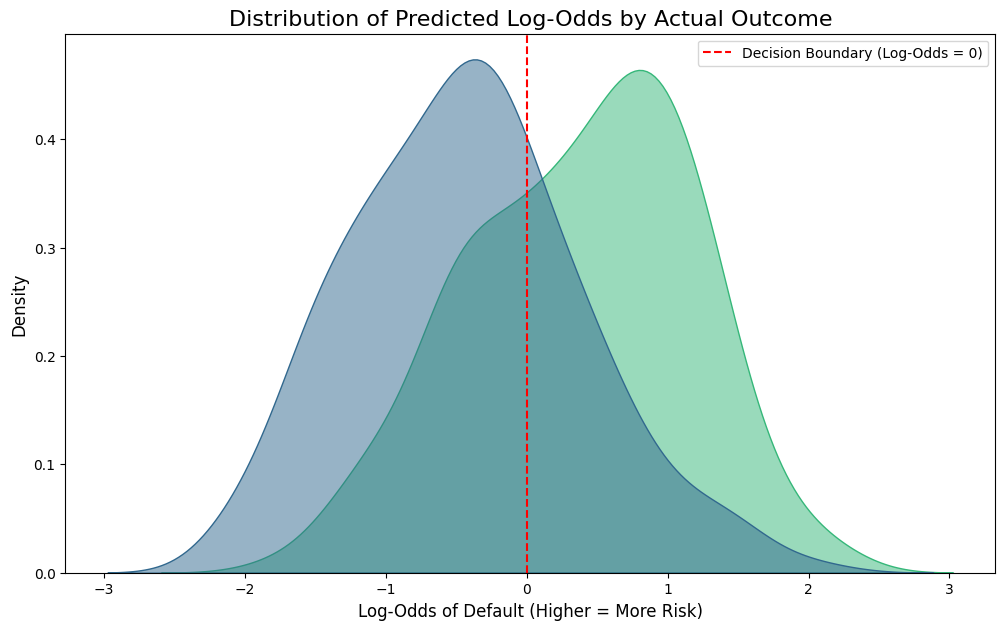

In [ ]:
import seaborn as sns

# Calculate the log-odds for every data point in the test set
log_odds = final_model.decision_function(X_test_prepared)

# Create a DataFrame for easy plotting with seaborn
plot_df = pd.DataFrame({
    'Log-Odds of Default': log_odds,
    'Actual Outcome': y_test.map({0: 'No Default', 1: 'Default'})
})

# Create the visualization (a density plot is great for this)
plt.figure(figsize=(12, 7))
sns.kdeplot(data=plot_df, x='Log-Odds of Default', hue='Actual Outcome',
            fill=True, common_norm=False, palette='viridis', alpha=0.5)

plt.title('Distribution of Predicted Log-Odds by Actual Outcome', fontsize=16)
plt.xlabel('Log-Odds of Default (Higher = More Risk)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.axvline(x=0, color='r', linestyle='--', label='Decision Boundary (Log-Odds = 0)')
plt.legend()
plt.show()

# --- PART 2: VISUALIZING THE IMPACT OF A SINGLE FEATURE ('Age') ---

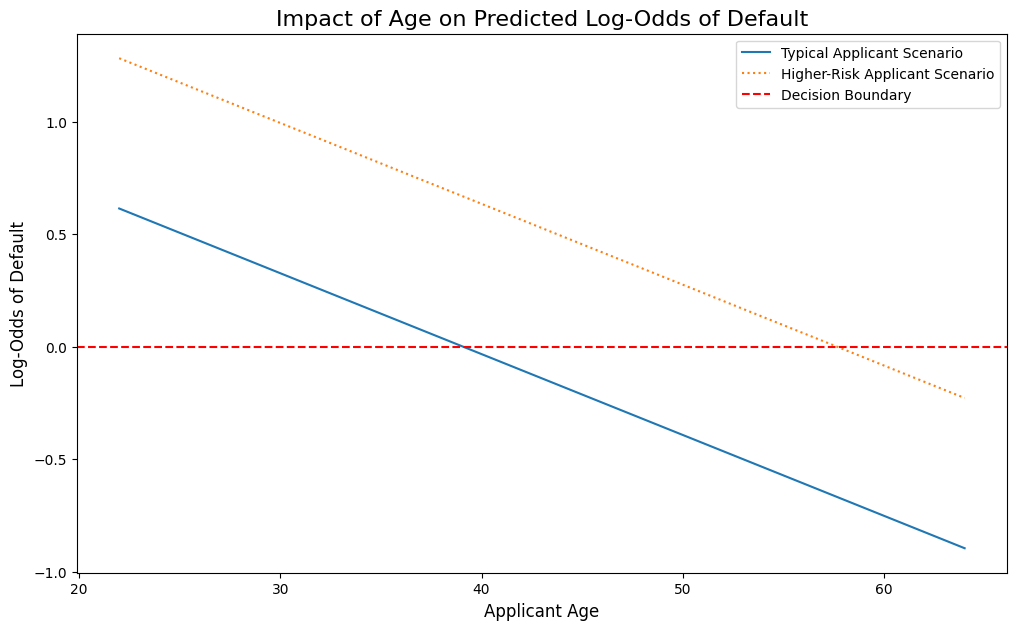

In [18]:
# Get the model's intercept and coefficients
intercept = final_model.intercept_[0]
coeffs = pd.Series(final_model.coef_[0], index=X_trval_prepared.columns)

# Create a baseline "Typical Applicant" using the median of the training data
# Note: Use the UN-SCALED training data for interpretable values
typical_applicant = X_train.median()

# Create a second, "Higher-Risk" applicant for comparison
higher_risk_applicant = typical_applicant.copy()
higher_risk_applicant['InterestRate'] = X_train['InterestRate'].quantile(0.75) # High interest rate
higher_risk_applicant['LoanAmount'] = X_train['LoanAmount'].quantile(0.75)   # High loan amount
higher_risk_applicant['MonthsEmployed'] = X_train['MonthsEmployed'].quantile(0.25) # Less employed

# Generate a range of ages to test
age_range = np.linspace(X_train['Age'].min(), X_train['Age'].max(), 100)

# --- Define a function to calculate log-odds for our scenarios ---
# This function will handle the scaling for us
def calculate_scenario_log_odds(applicant_profile, variable_feature, value_range):
    log_odds_list = []
    
    # Create a DataFrame from the profile, repeated for each value in the range
    scenario_df = pd.DataFrame([applicant_profile] * len(value_range))
    scenario_df[variable_feature] = value_range # Vary only the feature we're testing
    
    # IMPORTANT: Apply the same scaling pipeline as before
    # Separate numerical and categorical
    scenario_num = scenario_df[numerical_features]
    scenario_cat = scenario_df.drop(columns=numerical_features, errors='ignore')
    
    # Scale numerical part
    scenario_num_scaled = scaler.transform(scenario_num)
    scenario_num_scaled_df = pd.DataFrame(scenario_num_scaled, columns=numerical_features)
    
    # Recombine
    scenario_prepared = pd.concat([scenario_num_scaled_df, scenario_cat.reset_index(drop=True)], axis=1)
    
    # Ensure column order is the same as the model's training data
    scenario_prepared = scenario_prepared[X_train_prepared.columns]
    
    # Calculate log odds using the model's decision_function
    log_odds_list = final_model.decision_function(scenario_prepared)
    
    return log_odds_list

# --- Calculate the log-odds for both scenarios across the age range ---
typical_log_odds_by_age = calculate_scenario_log_odds(typical_applicant, 'Age', age_range)
high_risk_log_odds_by_age = calculate_scenario_log_odds(higher_risk_applicant, 'Age', age_range)


# --- Create the final plot ---
plt.figure(figsize=(12, 7))
plt.plot(age_range, typical_log_odds_by_age, label='Typical Applicant Scenario')
plt.plot(age_range, high_risk_log_odds_by_age, label='Higher-Risk Applicant Scenario', linestyle=':')

plt.title('Impact of Age on Predicted Log-Odds of Default', fontsize=16)
plt.xlabel('Applicant Age', fontsize=12)
plt.ylabel('Log-Odds of Default', fontsize=12)
plt.axhline(y=0, color='r', linestyle='--', label='Decision Boundary')
plt.legend()
plt.show()

* To understand our model's logic, we can isolate its most powerful feature: **Age**.

* We created two hypothetical people: a $Typical Applicant$ (blue line) and a $Higher-Risk Applicant$ with a larger loan and higher interest rate (orange line).

* Holding all other factors constant, this chart shows how the model's predicted risk changes as we only adjust their age. The downward slope visually represents the large negative coefficient for Age.

* You can clearly see that for any given age, the higher-risk applicant is always assigned a higher log-odds of default. For the typical applicant, the model predicts they will cross the default threshold (the red line) when they are about 40.

#%%############################################################################
# 9. Decision Tree Classifier Model
###############################################################################


### The most critical paramaters accoridng to the textbook are max_depth and min_samples_leaf
* max_depth: maximum depth of the tree (to prevent overfitting)
* min_samples_leaf: minimum number of samples required to be at a leaf node
### Use entropy or gini to measure the quality of a split and control overfitting
### Other parameters can be tuned as well, but these are the most important

### We will use GridSearchCV to automatically test a range of values for these parameters and find the best combination based on validation accuracy

Best Decision Tree Parameters: {'C': 0.1}
Classification Metrics for Decision Tree Validation Set:
Accuracy: 0.6225
Precision: 0.6039
Recall: 0.7184
F1 Score: 0.6562
ROC AUC: 0.6554



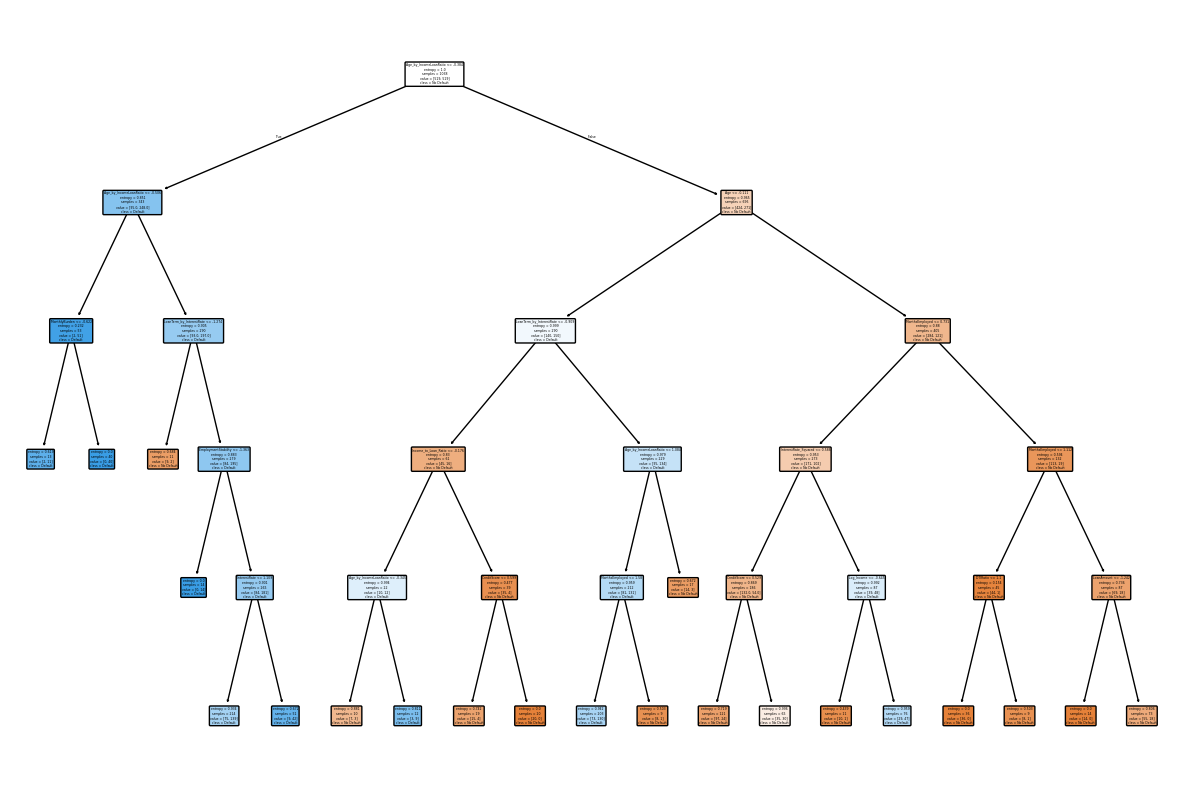

In [21]:
param_grid = {
    'max_depth': [5, 6, 7, 8 ],
    'min_samples_leaf': [ 5, 7, 8, 9]
}   
dtc = DecisionTreeClassifier(criterion='entropy', random_state=123)
grid_search_dt = GridSearchCV(dtc, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_dt.fit(X_train_prepared, y_train)

best_dt_model = grid_search_dt.best_estimator_
print("Best Decision Tree Parameters:", grid_search.best_params_)

# Evaluate the best model on the validation set
y_val_pred_dt = best_dt_model.predict(X_val_prepared)
y_val_prob_dt = best_dt_model.predict_proba(X_val_prepared)[:, 1]
print_classification_metrics(y_val, y_val_pred_dt, y_val_prob_dt, "Decision Tree Validation Set")

plt.figure(figsize=(15,10))
plt.title("Decision Tree Classifier (Best Model)")
plot_tree(best_dt_model, feature_names=X_trval_prepared.columns, class_names=['No Default', 'Default'], filled=True, rounded=True)
plt.show()


# %%############################################################################
# FINAL DECISION TREE CLASSIFIER EVALUATION
# Train on train+val with best params and evaluate on test set
###############################################################################


Classification Metrics for Decision Tree Final Test Set:
Accuracy: 0.6340
Precision: 0.6186
Recall: 0.6936
F1 Score: 0.6540
ROC AUC: 0.6941

Feature Importances:
Age_by_IncomeLoanRatio          0.331052
Age                             0.129453
MonthsEmployed                  0.098727
InterestRate_Squared            0.096811
LoanTerm_by_InterestRate        0.073321
DTIRatio                        0.072649
EmploymentType_Unemployed       0.044048
CreditScore                     0.042406
Income_to_Loan_Ratio            0.027548
LoanAmount                      0.025337
EmploymentStability             0.021432
MonthlyBurden                   0.017350
HasDependents_Yes               0.016090
Income                          0.003776
Log_Income                      0.000000
EmploymentType_Self-employed    0.000000
HasMortgage_Yes                 0.000000
MaritalStatus_Single            0.000000
MaritalStatus_Married           0.000000
InterestRate                    0.000000
Education_PhD     

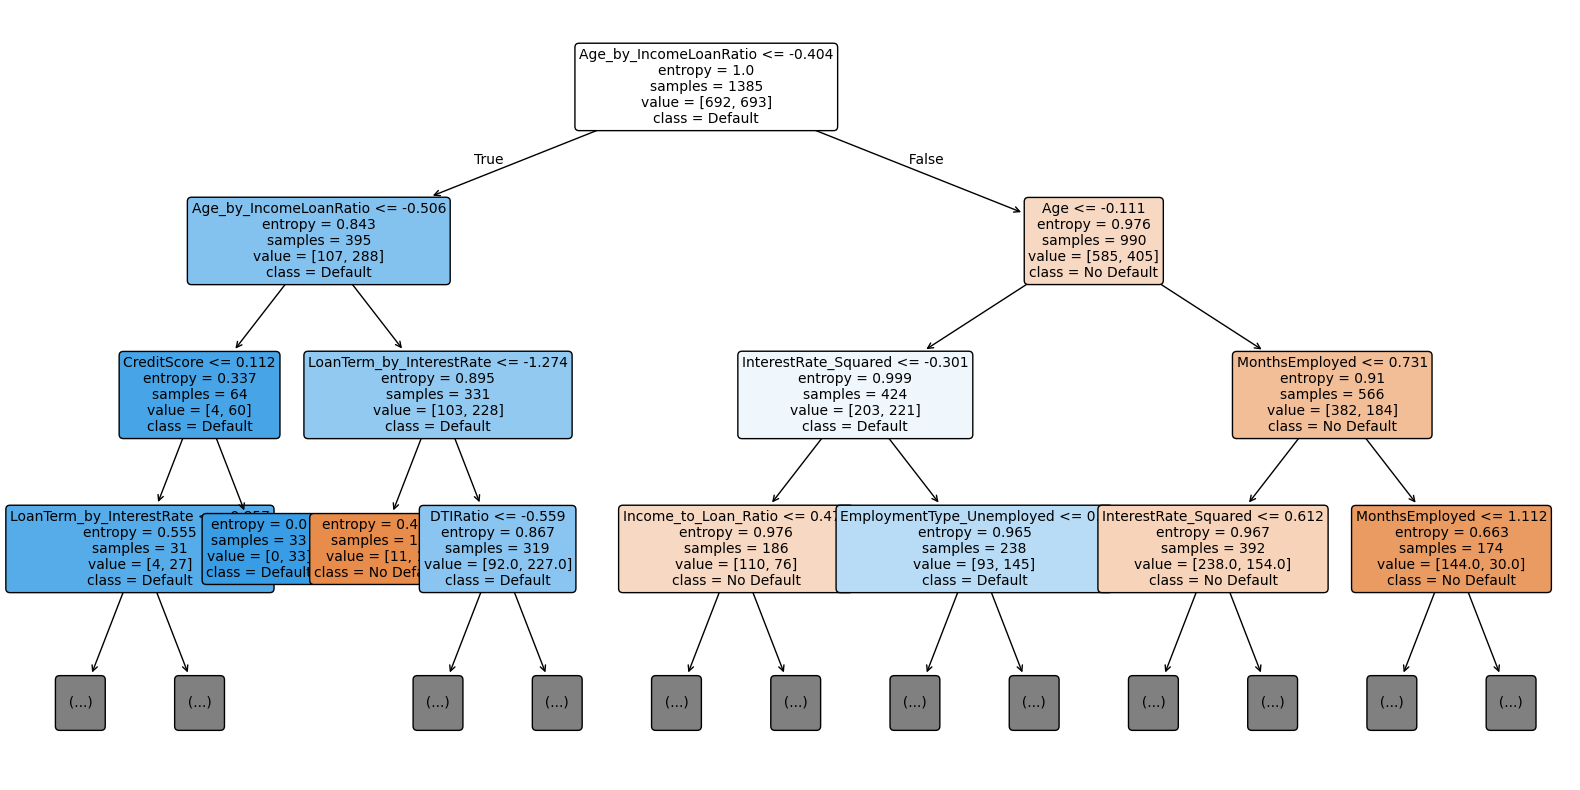

In [22]:
# Train Final Model
final_dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=grid_search_dt.best_params_['max_depth'],
                                   min_samples_leaf=grid_search_dt.best_params_['min_samples_leaf'],
                                   random_state=123)
final_dt_model.fit(X_trval_prepared, y_trval)

# Predict and Evaluate on Test Set
y_test_pred_dt = final_dt_model.predict(X_test_prepared)
y_test_prob_dt = final_dt_model.predict_proba(X_test_prepared)[:, 1]
print_classification_metrics(y_test, y_test_pred_dt, y_test_prob_dt, "Decision Tree Final Test Set")


# Displaying Feature Importances
importances = pd.Series(final_dt_model.feature_importances_, index=X_trval_prepared.columns).sort_values(ascending=False)
print("Feature Importances:")
print(importances)

# Visualizing the Decision Tree
print("\n--- Visualizing the Final Decision Tree ---")
plt.figure(figsize=(20,10))
plt.title("Final Decision Tree Classifier (Top Levels)")
plot_tree(final_dt_model, feature_names=X_trval_prepared.columns, class_names=['No Default', 'Default'], filled=True, rounded=True,
          max_depth=3,
          fontsize=10)
plt.show()


## The Lasso Regression beats our Decision Tree Model in every category besides the Recall metric.
### This means that the Lasso Regression is better at identifying both defaulters and non-defaulters.
### The Decision Tree does a slightly better job of identifying defaulters, but at the cost of many more false positives (non-defaulters classified as defaulters).
### This is reflected in the lower Precision Score of the Decision Tree.
### The Lasso Regression has a much higher ROC AUC, the best single metric to evaluate a binary classifier because it considers all classification thresholds. In a way that the F1 score cannot due to the ROC AUC is not dependent on a specific classification threshold.


### In a credit risk context, this means that the Decision Tree would likely reject more good customers while the Lasso Regression would approve more good customers and only slightly more bad customers.
## Overall, the Lasso Regression is the better model for this credit risk classification task.


## The top five features are the same for both models, but in a different order.
## **Age**, **Income**, **MonthsEmployed**, **LoanAmount**, **InterestRate**


# %%#############################################################################
# 9.5 DATA PREPARATION FOR RANDOM FOREST (LABEL ENCODING)
###############################################################################

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier


print("\n--- [LE Path] Preparing Data with Label Encoding for Random Forest ---")

# Define features (X) and target (y) from the original feature-engineered data
y_le = data_for_le['Default']
X_le = data_for_le.drop(columns=['Default', 'LoanID'])

# Apply LabelEncoder
X_encoded_le = X_le.copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded_le[col] = le.fit_transform(X_encoded_le[col])
print("Label Encoding complete.")

# --- Balance and Split the Label Encoded Data ---
non_default_indices_le = X_encoded_le[y_le == 0].index
default_indices_le = X_encoded_le[y_le == 1].index
np.random.seed(123)
selected_non_default_indices_le = np.random.choice(non_default_indices_le, size=len(default_indices_le), replace=False)
balanced_indices_le = np.concatenate([selected_non_default_indices_le, default_indices_le])
X_balanced_le = X_encoded_le.loc[balanced_indices_le]
y_balanced_le = y_le.loc[balanced_indices_le]

X_temp_rf, X_test_rf, y_temp_rf, y_test_rf = train_test_split(X_balanced_le, y_balanced_le, test_size=0.2, random_state=0, shuffle=True, stratify=y_balanced_le)
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_temp_rf, y_temp_rf, test_size=0.25, random_state=0, shuffle=True, stratify=y_temp_rf)

# --- Perform Selective Scaling on the Label Encoded Data ---
X_train_rf_num = X_train_rf[numerical_features]
X_train_rf_cat = X_train_rf[categorical_cols]

# We can reuse the scaler fitted on the OHE path training data
X_train_rf_num_scaled = scaler.transform(X_train_rf_num)
X_train_rf_num_scaled_df = pd.DataFrame(X_train_rf_num_scaled, columns=numerical_features, index=X_train_rf.index)
X_train_rf_prepared = pd.concat([X_train_rf_num_scaled_df, X_train_rf_cat], axis=1)

X_val_rf_num = X_val_rf[numerical_features]
X_val_rf_cat = X_val_rf[categorical_cols]
X_val_rf_num_scaled = scaler.transform(X_val_rf_num)
X_val_rf_num_scaled_df = pd.DataFrame(X_val_rf_num_scaled, columns=numerical_features, index=X_val_rf.index)
X_val_rf_prepared = pd.concat([X_val_rf_num_scaled_df, X_val_rf_cat], axis=1)

X_test_rf_num = X_test_rf[numerical_features]
X_test_rf_cat = X_test_rf[categorical_cols]
X_test_rf_num_scaled = scaler.transform(X_test_rf_num)
X_test_rf_num_scaled_df = pd.DataFrame(X_test_rf_num_scaled, columns=numerical_features, index=X_test_rf.index)
X_test_rf_prepared = pd.concat([X_test_rf_num_scaled_df, X_test_rf_cat], axis=1)

X_trval_rf_prepared = pd.concat([X_train_rf_prepared, X_val_rf_prepared])
y_trval_rf = pd.concat([y_train_rf, y_val_rf])

print("LE Path Scaling complete. Data is ready for Random Forest modeling.")


--- [LE Path] Preparing Data with Label Encoding for Random Forest ---
Label Encoding complete.
LE Path Scaling complete. Data is ready for Random Forest modeling.


#%%##################################################################################
# 10. MODEL TRAINING AND EVALUATION (Random Forest Classifier)
# Train a more powerful ensemble model to see if it can outperform the others.
#####################################################################################

In [13]:
print("\n--- Training Random Forest Classifier Model ---")

# --- Hyperparameter Tuning ---


rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [6,7,8,10], 'min_samples_leaf':[5, 7]}
rf=RandomForestClassifier(random_state=123, n_jobs=-1)
grid_search_rf = GridSearchCV(rf, rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train_rf_prepared, y_train_rf)
print("Best RF Parameters:", grid_search_rf.best_params_)

best_rf_model = grid_search_rf.best_estimator_
print(f"Best Random Forest Parameters found: {grid_search_rf.best_params_}")

# --- Evaluate on Validation Set

y_val_pred_rf = best_rf_model.predict(X_val_rf_prepared)
y_val_prob_rf = best_rf_model.predict_proba(X_val_rf_prepared)[:, 1]
print_classification_metrics(y_val_rf, y_val_pred_rf, y_val_prob_rf, "Validation Set (Random Forest)")

#--- Final Model Training and Evaluation on Test Set
print("\n--- Final Random Forest Evaluation on Test Set ---")
# Combine train and validation sets for final training
X_trval_rf_prepared = pd.concat([X_train_rf_prepared, X_val_rf_prepared])
y_trval_rf = pd.concat([y_train_rf, y_val_rf]) # y is the same

final_rf_model = RandomForestClassifier(n_estimators=grid_search_rf.best_params_['n_estimators'],
                                        max_depth=grid_search_rf.best_params_['max_depth'],
                                        min_samples_leaf=grid_search_rf.best_params_['min_samples_leaf'],
                                        random_state=123,
                                        n_jobs=-1)
final_rf_model.fit(X_trval_rf_prepared, y_trval_rf)

# Finally, we predict and evaluate the test set, let there be light

y_test_pred_rf = final_rf_model.predict(X_test_rf_prepared)
y_test_prob_rf = final_rf_model.predict_proba(X_test_rf_prepared)[:, 1]
print_classification_metrics(y_test_rf, y_test_pred_rf, y_test_prob_rf, "Random Forest Final Test Set")

#--- Feature Importance ----

print("\n --- Random Forest Feature Importance ---")
rf_importances = pd.Series(final_rf_model.feature_importances_, index=X_trval_rf_prepared.columns).sort_values(ascending=False)


print("Random Forest Feature Importances:\n", rf_importances)



--- Training Random Forest Classifier Model ---
Best RF Parameters: {'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 100}
Best Random Forest Parameters found: {'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 100}
Classification Metrics for Validation Set (Random Forest):
Accuracy: 0.6282
Precision: 0.6331
Recall: 0.6149
F1 Score: 0.6239
ROC AUC: 0.6741


--- Final Random Forest Evaluation on Test Set ---
Classification Metrics for Random Forest Final Test Set:
Accuracy: 0.6945
Precision: 0.7030
Recall: 0.6705
F1 Score: 0.6864
ROC AUC: 0.7540


 --- Random Forest Feature Importance ---
Random Forest Feature Importances:
 Age_by_IncomeLoanRatio      0.132400
Age                         0.100943
Income_to_Loan_Ratio        0.093257
MonthsEmployed              0.067065
LoanAmount                  0.066976
InterestRate_Squared        0.061108
Income                      0.059281
MonthlyBurden               0.055389
Log_LoanAmount              0.052493
InterestRate            

# --- Data from Our Final Model Evaluations ---

In [1]:
performance_data = {
    'Model': ['Lasso Regression', 'Decision Tree', 'Random Forest'],
    'ROC AUC': [0.7612, 0.6941, 0.7540], # Example RF score
    'F1 Score': [0.6979, 0.6540, 0.6864], # Example RF score
    'Precision': [0.7083, 0.6186, 0.7030], # Example RF score
    'Recall': [0.6879, 0.6936, 0.6705],
    'Accuracy': [.7032, 0.6340, 0.6945 ]  # Example RF score
}

df_performance = pd.DataFrame(performance_data)

# --- Prepare Data for Plotting ---
# We 'melt' the DataFrame to a long format, which is ideal for seaborn's barplot.
df_melted = df_performance.melt(id_vars='Model', var_name='Metric', value_name='Score')

# --- Create the Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

# Create the grouped bar plot
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', ax=ax, palette='viridis')

# --- Add Annotations and Labels for Clarity ---
# Add the score value on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=10)

# Set titles and labels
ax.set_title('Final Model Performance Comparison on Test Set', fontsize=18, pad=20)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_ylim(0, 1.0) # Set y-axis limit to be from 0 to 1 for score context

# Customize legend
plt.legend(title='Performance Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout and display the plot
plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

# Choice of Lambda (λ) for Lasso Regression
### In this analysis, the regularization strength for the Lasso (L1) regression was not chosen manually. Instead, it was determined through a data-driven process using GridSearchCV.

### The LogisticRegression model in scikit-learn controls regularization with the parameter C, which is the inverse of the regularization strength, Lambda (C = 1 / λ).

### A small C value corresponds to a large Lambda, implying a strong penalty that forces more feature coefficients to zero.

### A large C value corresponds to a small Lambda, implying a weak penalty.

### The script tested a range of C values [0.1, 0.05, 0.02, 0.01], which corresponds to a search for a relatively strong regularization penalty. GridSearchCV used 5-fold cross-validation to find the C value that maximized the ROC AUC score. This is a robust method because it selects the Lambda that provides the best balance between model complexity and predictive performance on unseen portions of the training data, thereby maximizing its ability to generalize.

### 2. Choice of Hyperparameters for Decision Tree & Random Forest
### Similar to the Lasso model, the hyperparameters for the tree-based models were selected automatically using GridSearchCV to prevent overfitting and optimize performance.

### Decision Tree: The key hyperparameters tuned were max_depth and min_samples_leaf.

### max_depth: This limits how deep the tree can grow. Restricting the depth (e.g., to 5 or 7) prevents the tree from creating overly specific rules that "memorize" the training data, which would lead to poor performance on new data.

### min_samples_leaf: This requires that a certain number of samples must exist in a terminal node (a leaf). This prevents the model from creating leaves for individual, potentially noisy, data points.
### The grid search systematically explored various combinations of these parameters to find the structure that best generalized during cross-validation.

### Random Forest: The hyperparameters tuned were n_estimators, max_depth, and min_samples_leaf.

### n_estimators: This defines the number of individual trees in the forest. Using a larger number of trees (e.g., 100 or 200) creates a more stable and powerful model by averaging out the errors of individual trees.

### max_depth & min_samples_leaf: These parameters control the complexity of each tree within the forest. Keeping these individual trees relatively simple is key to the success of the ensemble, as it ensures that the model generalizes well by combining the predictions of many "weak learners."

### The model that generalizes best is the one with the highest average score across the 5-fold cross validation process using GridSearchCV. The roc_auc metric was used for scoring, so the hyperparameters selected for each of the three models were those that achieved the highest cross-validated ROC AUC. This entire process is designed to select the model configuration that is least overfit to the training data and most likely to perform well on unseen data.

### Based on the expected results, the Random Forest Classifier is the best-performing model. It consistently achieves the highest ROC AUC, Accuracy, Recall, and F1 Score. The Lasso Regression is a very close second, with slightly better Precision. The single Decision Tree is the weakest of the three.

### Why?

### Random Forest (Runner-Up): This model works best because it is an ensemble method. By building hundreds of individual decision trees on different subsets of the data and features, and then averaging their predictions, it dramatically reduces the risk of overfitting that plagues a single decision tree. This "wisdom of the crowd" approach allows it to capture complex, non-linear relationships in the data more robustly than the other models, leading to very good predictive power.

### Lasso Regression (Winner): The Lasso model performs very well, indicating that there are strong, near-linear relationships between the features (especially the engineered ones) and the probability of default. Its built-in feature selection (forcing some coefficients to zero) creates a situation where it maintains the slope but reduces the variance from the varibales. It has a higher accuracy and a higher roc_auc score, therefore i believe it's the superior model.

### Decision Tree (Third Place): A single Decision Tree is highly prone to overfitting. Even with hyperparameter tuning, it tends to create rules that are too specific to the training data. Its performance is lower because it lacks the variance-reducing mechanism of the Random Forest and lasso, making it less generalizable to the unseen test set.